![book header](pictures/header.png)

In [24]:
# Import necessary libraries
import matplotlib.pyplot as plt           # For plotting purposes
import numpy as np                        # For convolution function
from scipy.io import wavfile
from scipy.signal import find_peaks
import time

# Uncomment one of the following lines depending on your setup

# If you are using the real car, uncomment the next lines and comment the simulator lines
# from serial import Serial
# from pyaudio import PyAudio, paInt16

# If you are using the simulator, uncomment the next lines and comment the real car lines
from KITT_Simulator.serial_simulator import Serial
from KITT_Simulator.py_audio_simulator import PyAudio, paInt16

# Note: After changing the import statement, you need to restart the kernel for changes to take effect.

# Chapter 5:
# Module 3 - Locating KITT Using Audio Communication

KITT must be located in its field, and directions must be determined to navigate to the final destination. In previous modules, your colleagues have developed scripts to communicate with KITT and read sensor data. You will focus on locating KITT using audio signals received by microphones placed around the field. It is recommended that you read Modules 1 and 2 and talk to the other sub-group frequently. Otherwise the odds of your codes working together are very small.

For localization, we will use recordings of the beacon signal at various microphones, deconvolve these using a reference signal, and determine the relative time delays from the resulting channel estimates. These time differences, known as Time Difference of Arrival (TDOA), can be used to estimate KITT's position within the field.

At the end of this module, you will have developed a script to locate KITT within the field with reasonable accuracy, using the data recorded by the microphones. You will also have tested and verified the accuracy and robustness of your solution.

## Pre-recorded Data

To get you started, we have provided 7 recordings at known locations and a reference recording taken close to one of the microphones. These can be used to develop and test your algorithms. The recordings are at locations randomly distributed across the field, as follows:

| Recording Index |   x [cm]   |   y [cm]   |
|-----------------|------------|------------|
| 0               |    64      |    40      |
| 1               |    82      |   399      |
| 2               |   109      |    76      |
| 3               |   143      |   296      |
| 4               |   150      |   185      |
| 5               |   178      |   439      |
| 6               |   232      |   275      |

*Table 1: Locations of the given recordings (in cm)*

The x and y axes of the field are defined as follows, where the numbers refer to the microphone index:

<img src="pictures/axisdef.png" alt="Field axis and microphone index definition" width="250px">

*Figure: Field axis and microphone index definition*

You can assume these positions for the microphones (note the different height of microphone 5):

| Microphone |   x [cm]   |  y [cm] |  z [cm] |
|------------|------------|---------|---------|
| 1          |     0      |    0    |    50   |
| 2          |     0      |   480   |    50   |
| 3          |    480     |   480   |    50   |
| 4          |    480     |    0    |    50   |
| 5          |     0      |   240   |    80   |

*Table 2: Locations of the microphones (in cm)*

### Loading and Plotting the Provided Recordings

The code below helps you load and plot the first of the 7 audio signals provided. 

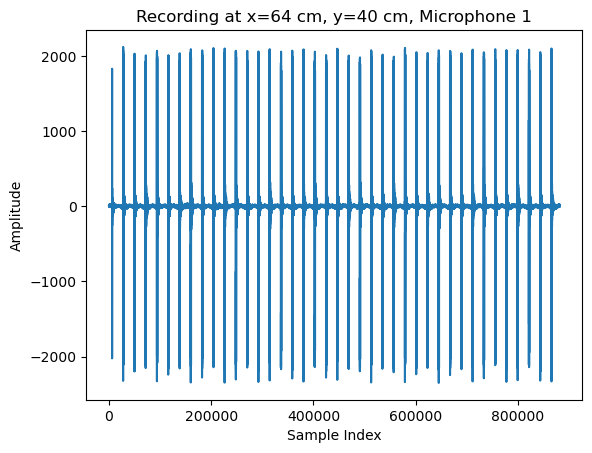

In [25]:
# Coordinates of the recordings
record_x = [64, 82, 109, 143, 150, 178, 232]
record_y = [40, 399, 76, 296, 185, 439, 275]

# List to store filenames
filenames = []

# Generate filenames based on coordinates
for i in range(len(record_x)):
    real_x = record_x[i]
    real_y = record_y[i]
    filenames.append(f"Files/Student Recordings/record_x{real_x}_y{real_y}.wav")

# Load the first recording
Fs, recording = wavfile.read(filenames[0])

# Plot the first channel of the first recording
plt.plot(recording[:, 0])
plt.title(f"Recording at x={record_x[0]} cm, y={record_y[0]} cm, Microphone 1")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

Play around with the recordings and try to understand the data you are working with. Try the following:
- Load and plot an other recording.
- Zoom in on one of the pulses.
- Of one pulse, overlay the different microphones. Can you spot the time differences? Can you determine in which corner of the field the recording was made?

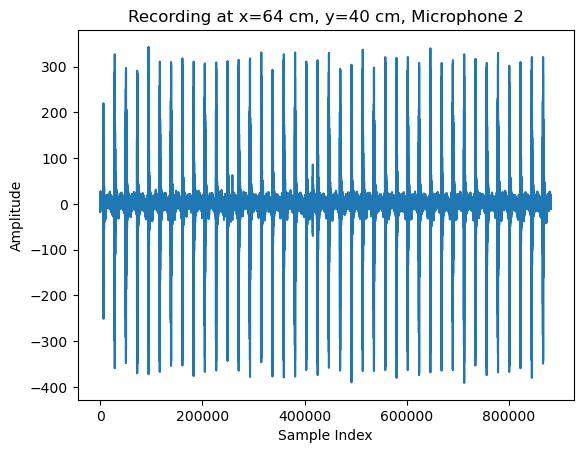

In [26]:
# Plot the second recording
Fs, recording = wavfile.read(filenames[1])

plt.plot(recording[:, 0])
plt.title(f"Recording at x={record_x[0]} cm, y={record_y[0]} cm, Microphone 2")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

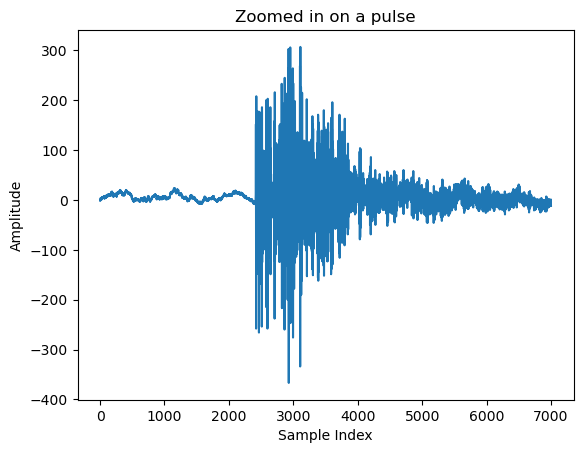

In [27]:
# Zoom in on one of the pulses
plt.plot(recording[202000:209000, 0])
plt.title("Zoomed in on a pulse")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

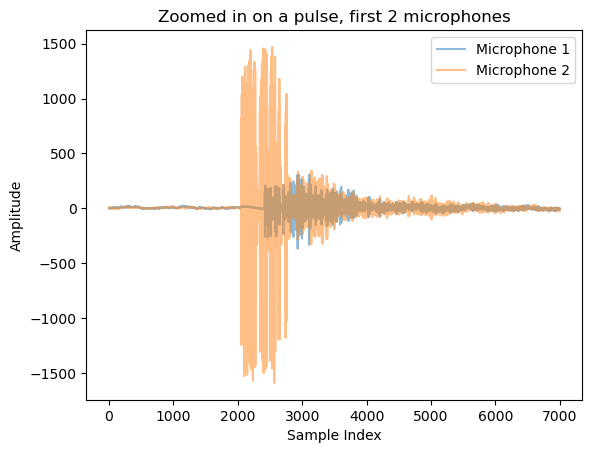

In [28]:
# Of one pulse, overlay the different microphones.
plt.plot(recording[202000:209000, 0], alpha=0.5)
plt.plot(recording[202000:209000, 1], alpha=0.5)
plt.title("Zoomed in on a pulse, first 2 microphones")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend(["Microphone 1", "Microphone 2"])
plt.show()

In [22]:
### Student Version ###


*Hints:*
- You can select the recording by changing the index in: ```Fs, recording = wavfile.read(filenames[index])```.
- You can select the microphones by changing the index in: ```recording[:, mic]```.
- The recordings are sampled at 44.1 kHz.

## Background Knowledge

In the first weeks assignment, you developed algorithms for channel estimation using signals received at two microphones. In this module, we extend this to 5 microphones and use this to locate the car.

### Channel Estimation

The channel estimation problem is as follows:

Suppose we transmit a known signal \( x[n] \) over a communication channel and measure the received signal \( y[n] \). The channel acts as a filter, which we will assume to be linear and time-invariant (LTI). Therefore, the received signal is a convolution of the transmitted signal by the channel impulse response \( h[n] \):

$$
y[n] = x[n] * h[n]
$$

Knowing the transmitted signal \( x[n] \), can we recover the impulse response of the communication channel \( h[n] \) from \( y[n] \)? This is essentially an inversion problem.

#### Channel Estimation Algorithms

There are several methods for channel estimation:

1. **Deconvolution in Time Domain (ch1):** Involves matrix inversion. It is computationally complex and requires lots of memory.

2. **Matched Filter (ch2):** Avoids matrix inversion by computing the cross-correlation of \( y[n] \) with \( x[n] \). The channel estimate is given by:

$$
\hat{h}[n] = y[n] * x[-n]
$$

This method depends heavily on having a reference signal with good autocorrelation properties.

3. **Deconvolution in Frequency Domain (ch3):** Involves using the Fast Fourier Transform (FFT). Convolution in time becomes multiplication in frequency, so deconvolution becomes division in the frequency domain:

$$
\hat{H}[k] = \frac{Y[k]}{X[k]}
$$

Then, the channel impulse response \( \hat{h}[n] \) is obtained by taking the inverse FFT of \( \hat{H}[k] \).

This method is efficient but requires handling divisions by zero or very small values, which can be achieved by thresholding.

**Note:** We recommend using method **ch3** (Deconvolution in Frequency Domain) for this module.

### Time Difference of Arrival (TDOA)

After estimating the channel impulse response for each microphone, we can detect the first incoming path (the direct path from KITT to the microphone). This corresponds to the propagation delay of the car beacon to each microphone. However, since we do not know the exact transmission time, we can only obtain relative propagation delays. By taking the differences of these delays between pairs of microphones, we eliminate the unknown transmission time, resulting in Time Difference of Arrival (TDOA) measurements.

These TDOA measurements can be used to estimate the position of KITT in the field.

---

## Step 1: Implementing Channel Estimation

Using the provided reference signal and your channel estimation algorithm (ch3: deconvolution in the frequency domain), deconvolve the recordings to obtain the channel impulse response for each microphone.

#### Steps:

1. **Load and Normalize the Reference Signal:**

   - The reference signal is provided as a WAV file recorded close to one of the microphones.
   - Normalize the reference signal to have a maximum amplitude of 1.

2. **Load and Normalize the Recorded Signals:**

   - Load the recordings from the provided files.
   - Normalize the recordings similarly.

3. **Segment the Signals:**

   - Extract a single pulse from the reference signal and the recordings.
   - You may need to determine the start and end points of the pulse manually.

4. **Implement the Channel Estimation Algorithm:**

   - Use deconvolution in the frequency domain (ch3) to estimate the channel impulse response.
   - Be sure to handle divisions by zero or very small values in the frequency domain by applying a threshold.

**Notes and Hints:**

- **Normalization:** You can normalize a signal by dividing it by its maximum absolute value:

  ```python
  ref_signal = ref_signal / np.max(np.abs(ref_signal))
  ```

- **Segmentation:** To extract one pulse, you need to find the start index of a pulse in the recording. You can do this by inspecting the plot of the recording or by implementing an automatic pulse detection algorithm.

- **FFT Length:** When performing convolution or deconvolution via FFT, ensure that the FFT length is sufficient to avoid circular convolution effects. Using `n = len(ref_pulse) + len(rec_pulse) - 1` ensures linear convolution.

- **Thresholding:** Adjust the threshold value based on the magnitude of the FFT of the reference signal.

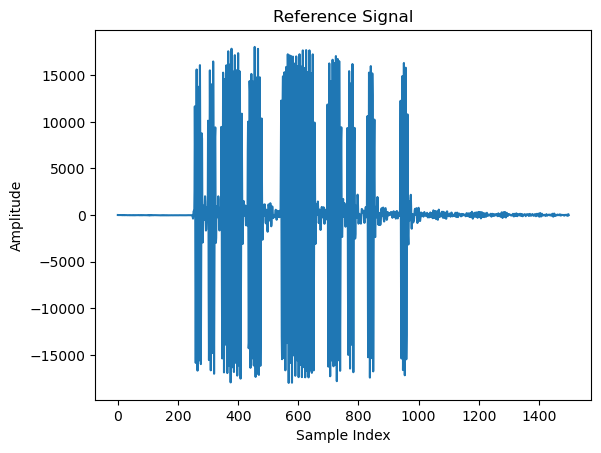

In [30]:
# Load and normalize the reference signal
Fs_ref, ref_signal = wavfile.read("Files/Student Recordings/reference.wav")
ref_signal = ref_signal[221000:222500, 0]  # Use only one channel
# TODO: Normalize the reference signal

# Plot the reference signal
plt.figure()
plt.plot(ref_signal)
plt.title("Reference Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# TODO: Load a recorded signal
# TODO: Normalize the recording

# TODO: Select one channel

# Plot the recorded signal
plt.figure()
plt.plot(recording)
plt.title("Recorded Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# TODO: Segment the recording to extract one pulse

# Plot the segmented reference signal
plt.figure()
plt.plot(recording_pulse)
plt.title("Segmented Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# TODO: Implement the channel estimation algorithm (deconvolution in frequency domain)
def channel3(ref_pulse, rec_pulse):
    pass

# Estimate the channel impulse response

h_est = channel3(ref_pulse, recording_pulse)

# Plot the estimated channel impulse response
plt.figure()
plt.plot(h_est)
plt.title("Estimated Channel Impulse Response")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

## Step 2: Determining Time of Arrivals (TOAs)

From the peaks in the channel impulse responses, determine the Time of Arrivals (TOAs) and store these in a table.

#### Steps:

1. **Identify the Peaks in the Channel Impulse Responses:**

   - The first significant peak corresponds to the direct path from KITT to the microphone.

2. **Calculate the TOAs:**

   - Convert the sample indices to time values using the sampling frequency.

3. **Store the TOAs:**

   - Collect the TOAs for each microphone and store them in a structured format (e.g., a dictionary or table).

**Notes and Hints:**

- The index of the maximum value in the channel impulse response can be found using:

  ```python
  peak_index = np.argmax(np.abs(h_est))
  ```

- Convert the index to time using:

  ```python
  TOA = peak_index / Fs_rec
  ```

- Remember that the absolute time of transmission is unknown, so the TOAs are relative.

In [ ]:
# Identify the peak in the channel impulse response
peak_index = np.argmax(np.abs(h_est))

# Calculate the TOA (in seconds)
TOA = peak_index / Fs_rec

# Store the TOA for the microphone
# You can use a dictionary to store TOAs for multiple microphones
TOAs = {}
TOAs['Mic1'] = TOA

# Print the TOA
print(f"TOA for Microphone 1: {TOA} seconds")

## Step 3: Automating Pulse Segmentation

Extend your code to automatically segment the received data and find the beginning of each pulse.

#### Steps:

1. **Develop a Pulse Detection Algorithm:**

   - Use methods like envelope detection, thresholding, or moving averages to detect the start of pulses in the recordings.

2. **Segment the Recording into Individual Pulses:**

   - Once you detect the start indices of pulses, extract segments corresponding to each pulse.

3. **Process Multiple Pulses:**

   - If your recording contains multiple pulses, loop over them and estimate the channel for each one.

4. **Do a Sanity Check:**

   - Verify that the detected pulses align with the actual pulses in the recording.

**Notes and Hints:**

- **Pulse Detection:**

  - `find_peaks` from `scipy.signal` can be used to detect peaks in the envelope of the signal.
  - Adjust the `height` and `distance` parameters based on the characteristics of your signal.

- **Envelope Detection:**

  - The envelope of the signal can be obtained using the absolute value or by applying the Hilbert transform.

- **Adjusting TOA Calculation:**

  - Since each pulse starts at `start_idx`, you need to account for this when calculating the TOA.

- **Single Pulse Importance:**

  - You may be tempted to compute the channel response for the whole recording. However, the computational complexity of this approach is high. Instead, focus on a single pulse.

In [ ]:
# TODO: Develop a function to detect the start indices of pulses in the recording
# Takes signal and number of pulses in the recordings as input and returns a list of start indices
def detect_pulses(signal, num_pulses):
    return peaks

# Detect pulses in the recorded signal
pulse_starts = detect_pulses(recording_channel, num_pulses)

# TODO: Loop over each detected pulse and estimate the channel
TOAs = []
for start_idx in pulse_starts:

    TOAs.append(TOA)

## Step 4: Calculating TDOA Between Microphone Pairs

Complete the TDOA function to calculate the time difference of arrival between pairs of microphones.

#### Steps:

1. **Calculate TDOA Between Two Microphones:**

   - For each pair of microphones, calculate the difference in TOAs.

2. **Convert TDOA to Distance Difference:**

   - Use the speed of sound (approximately 343 m/s) to convert TDOA to distance difference.

3. **Store and Use TDOA Values:**

   - Collect TDOA values for all relevant microphone pairs.

#### Student Code:

```python
# Implement a function to calculate TDOA between two microphones
def calculate_tdoa(TOA1, TOA2):
    # Calculate the time difference
    tdoa = TOA2 - TOA1
    return tdoa

# Example TOAs for multiple microphones (you need to obtain these from your data)
TOAs = {
    'Mic1': 0.01234,
    'Mic2': 0.01356,
    'Mic3': 0.01178,
    'Mic4': 0.01290,
    'Mic5': 0.01210
}

# Calculate TDOA between Mic1 and other microphones
tdoa_12 = calculate_tdoa(TOAs['Mic1'], TOAs['Mic2'])
tdoa_13 = calculate_tdoa(TOAs['Mic1'], TOAs['Mic3'])
tdoa_14 = calculate_tdoa(TOAs['Mic1'], TOAs['Mic4'])
tdoa_15 = calculate_tdoa(TOAs['Mic1'], TOAs['Mic5'])

# Convert TDOA to distance difference
speed_of_sound = 343  # m/s
delta_d_12 = tdoa_12 * speed_of_sound
delta_d_13 = tdoa_13 * speed_of_sound
delta_d_14 = tdoa_14 * speed_of_sound
delta_d_15 = tdoa_15 * speed_of_sound

# Print the results
print(f"TDOA between Mic1 and Mic2: {tdoa_12} seconds")
print(f"Distance difference between Mic1 and Mic2: {delta_d_12} meters")

print(f"TDOA between Mic1 and Mic3: {tdoa_13} seconds")
print(f"Distance difference between Mic1 and Mic3: {delta_d_13} meters")

print(f"TDOA between Mic1 and Mic4: {tdoa_14} seconds")
print(f"Distance difference between Mic1 and Mic4: {delta_d_14} meters")

print(f"TDOA between Mic1 and Mic5: {tdoa_15} seconds")
print(f"Distance difference between Mic1 and Mic5: {delta_d_15} meters")
```

**Notes and Hints:**

- **Speed of Sound:**

  - Use \( v = 343 \) m/s for the speed of sound in air at room temperature.

- **Distance Difference:**

  - The distance difference \( \Delta d \) is given by:

    \[
    \Delta d = \text{TDOA} \times v
    \]

- **Microphone Pairs:**

  - You can calculate TDOA for all pairs involving Microphone 1 and the other microphones.
  - Additionally, you can calculate TDOA between other microphone pairs if needed.

---

## Deliverables

In your midterm report, document your algorithms, show examples of measurements and channel estimates, and include a subsection on testing, showing your findings and accuracies.

- **Algorithms:**

  - Explain the channel estimation method you used.
  - Describe how you automated pulse segmentation and TOA extraction.

- **Measurements and Channel Estimates:**

  - Include plots of the recordings, the segmented pulses, and the estimated channel impulse responses.
  - Show the peaks corresponding to the direct path.

- **Testing and Accuracy:**

  - Present the TOA and TDOA results.
  - Compare your estimated distance differences to the expected values based on the known positions.
  - Discuss any discrepancies and potential sources of error.

**Notes:**

- When plotting, consider showing both the full recording and zoomed-in views of individual pulses and channel estimates.
- Remember that for negative delays, the peak of interest may appear at the end of the impulse response due to circular convolution.

**Next Steps:**

In the next part of Module 3, you will use the TDOA measurements to develop localization algorithms and estimate KITT's position in the field.

## Localization using TDOA information

Now we arrive at the main question studied in this module: how can we locate the car using the TDOA
estimates? With 5 microphones, we can compute the TDOAs between all pairs of microphones and
obtain 10 TDOA pairs. Next, you need an algorithm to convert this into the $(x,y)$ location of the car. We offer two approaches for this:
 - Study Appendix C, which shows a basic algorithm to solve for $(x,y)$ using a linear algebra approach. This algorithm is sub-optimal but should be rather fast.
 - In the paragraph "Optional extensions" (below), a suggestion is given to do a grid search: scan all possible $(x,y)$ positions and see which position gives the best match to the estimated TDOAs. This is accurate but could be slow (depending on how you implement this). 

Although we compute the $(x,y)$ position, in reality the world is 3D and the microphones have a certain height above the height of the audio beacon (we define the beacon to sit at $z=0$). The algorithm in Appendix C does not take this height into account. However, this extension is straightforward (see under "Optional extensions").

### Localization algorithm assignments

**Task 1** Develop a test code using Pythagoras’ theorem that takes an (x, y) position as input and calculates
the TDOA that you would observe from this position. This involves calculating the distance from
the given point to each microphone. This will help you debug both your TDOA function and your
`coordinate_2d` function (see below).

**Task 2** 
Using the distances estimated previously and the microphone location, generate matrix A and vector b (introduced in appendix C) and use them to find the (x,y) location. Once you are sure it works for a few examples turn it into a function called `coordinate_2d`. As an illustration, you can also plot the room and show the true locations and estimated
locations.

**Task 3** Document the accuracy of your localization algorithm. Is this acceptable for your application?  For the midterm report, document your algorithm and the results of the tests on simulated and given test data. 

## Localization class

Now, it is time to start setting up a processing pipeline by putting everything together. The localization class you will develop will take a 5-channel recording of input and return the x and y coordinates of the car. Below is an outline of a localization class you could use. Note that this is to help you get started, and you will have to add methods and logic yourself. Look at the comments inside of the class for an explanation. Once you are done, you can copy this class in a separate file and import and use it in other modules.

In [ ]:
from scipy.io import wavfile
import logging
import scipy.signal as signal
from scipy.fft import fft, ifft
import numpy as np
import matplotlib.pyplot as plt

class Localization:
    def __init__(self, recording, refSignal, num_pulses, Fs):
        """
        Initializes the Localization class with the given recordings.
        
        Parameters:
        - recording: A 2D numpy array where each row is a recording from one microphone.
        - debug: Boolean to enable debug logging.
        """
        self.recording = recording
        self.num_pulses = num_pulses
        self.refSignal = refSignal
        self.Fs = Fs
        
        # Define the microphone positions in cm
        self.mic_positions = np.array([[0, 0], [0, 460], [460, 460], [460, 0], [0, 230]])
        
        # Localize the sound source for each pulse
        self.localizations = self.localization()

    def localization(self):
        """
        Localize the sound source by processing the recordings.
        
        Returns:
        - x_car: Estimated x-coordinate of the sound source.
        - y_car: Estimated y-coordinate of the sound source.
        """
        pulse_length = len(self.recording[:, 0]) // self.num_pulses  # Calculate the length of each pulse segment

        tdoa_12 = []
        tdoa_13 = []
        tdoa_14 = []

        for i in range(self.num_pulses):
            start = i * pulse_length
            end = start + pulse_length
            
            # Extract the pulse from each recording
            pulse_rec = self.recording[start:end, :]

            # Calculate TDOA between different microphone pairs using the extracted pulse
            D12 = self.TDOA(pulse_rec[:, 0], pulse_rec[:, 1])
            D13 = self.TDOA(pulse_rec[:, 0], pulse_rec[:, 2])
            D14 = self.TDOA(pulse_rec[:, 0], pulse_rec[:, 3])

            tdoa_12.append(D12)
            tdoa_13.append(D13)
            tdoa_14.append(D14)

        sorted_tdoa_12 = np.sort(tdoa_12)
        sorted_tdoa_13 = np.sort(tdoa_13)
        sorted_tdoa_14 = np.sort(tdoa_14)

        # plt.plot(sorted_tdoa_12, label="TDOA12")
        # plt.show()

        avg_D12 = np.mean(sorted_tdoa_12) * 34300
        avg_D13 = np.mean(sorted_tdoa_13) * 34300
        avg_D14 = np.mean(sorted_tdoa_14) * 34300

        # Calculate the 2D coordinates based on the averaged TDOA measurements
        x_car, y_car = self.coordinate_2d(avg_D12, avg_D13, avg_D14)
        
        return x_car, y_car

    def TDOA(self, rec1, rec2):
        """
        Calculate the Time Difference of Arrival (TDOA) between two recordings.
        
        Parameters:
        - rec1: Extracted pulse recording from the first microphone.
        - rec2: Extracted pulse recording from the second microphone.
        
        Returns:
        - TDOA: The estimated time difference of arrival between the two recordings.
        """
        # plt.plot(rec1, alpha=0.5)
        # plt.plot(rec2, alpha=0.5)
        # plt.show()

        # Cross-correlate the reference signal with each extracted pulse
        corr1 = self.ch3(rec1, self.refSignal)
        corr2 = self.ch3(rec2, self.refSignal)
        
        # Find the lag with the maximum correlation value (which corresponds to the arrival time)
        lag1 = np.argmax(corr1) - (len(self.refSignal) - 1)
        lag2 = np.argmax(corr2) - (len(self.refSignal) - 1)

        # Calculate TDOA
        TDOA = (lag2 - lag1) / self.Fs  # Convert lag difference to time difference in seconds

        # plt.plot(corr1, alpha=0.5)
        # plt.plot(corr2, alpha=0.5)
        # plt.scatter(lag1 + len(self.refSignal) - 1, corr1[np.argmax(corr1)], color='red')
        # plt.scatter(lag2 + len(self.refSignal) - 1, corr2[np.argmax(corr2)], color='red')
        # plt.show()
        
        return TDOA
    
    def ch3(self, x, y):
        Nx = len(x) # Length of x
        Ny = len(y) # Length of y
        L = Ny + Nx - 1 # Length of h
        self.epsi = 0.01
        if (Nx > Ny):
            y = np.concatenate((y, np.zeros(len(x) - len(y))))
        else:
            x = np.concatenate((x, np.zeros(len(y) - len(x))))

        # Deconvolution in frequency domain
        Y = fft(y)
        X = fft(x)
        H = Y / X

        # Threshold to avoid blow ups of noise during inversion
        ii = np.absolute(X) < self.epsi * max(np.absolute(X))
        for index, i in enumerate(ii):
            if i:
                H[index] = 0
            else:
                H[index] = H[index]

        h = np.real(ifft(H)) 
        # ensure the result is real-valued
        h = h[0:L]
        return h

    def coordinate_2d(self, D12, D13, D14):
        # Calculate other microphone differences
        D23 = (D13 - D12)
        D24 = (D14 - D12)
        D34 = (D14 - D13)

        print(f"D12: {D12}, D13: {D13}, D14: {D14}, D23: {D23}, D24: {D24}, D34: {D34}")

        # Microphone coordinates
        xyMic = np.array([[0, 0], [0, 460], [460, 460], [460, 0]])

        A = np.array([[2 * (xyMic[1, 0] - xyMic[0, 0]), 2 * (xyMic[1, 1] - xyMic[0, 1]), -2 * D12, 0, 0],
                      [2 * (xyMic[2, 0] - xyMic[0, 0]), 2 * (xyMic[2, 1] - xyMic[0, 1]), 0, -2 * D13, 0],
                      [2 * (xyMic[3, 0] - xyMic[0, 0]), 2 * (xyMic[3, 1] - xyMic[0, 1]), 0, 0, -2 * D14],
                      [2 * (xyMic[2, 0] - xyMic[1, 0]), 2 * (xyMic[2, 1] - xyMic[1, 1]), 0, -2 * D23, 0],
                      [2 * (xyMic[3, 0] - xyMic[1, 0]), 2 * (xyMic[3, 1] - xyMic[1, 1]), 0, 0, -2 * D24],
                      [2 * (xyMic[3, 0] - xyMic[2, 0]), 2 * (xyMic[3, 1] - xyMic[2, 1]), 0, 0, -2 * D34]
                      ])

        b = np.array([(pow(D12, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[1, :]), 2)),
                      (pow(D13, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D14, 2) - pow(np.linalg.norm(xyMic[0, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D23, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[2, :]), 2)),
                      (pow(D24, 2) - pow(np.linalg.norm(xyMic[1, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2)),
                      (pow(D34, 2) - pow(np.linalg.norm(xyMic[2, :]), 2) + pow(np.linalg.norm(xyMic[3, :]), 2))
                      ])

        y = np.linalg.inv(A.T @ A) @ A.T @ b
        return y[0:2]

if __name__ == "__main__":
    # read wav file in folder files
    Fs, recording = wavfile.read("files/student_recording/record_x143_y296.wav")
    num_pulses = 40  # Number of pulses in the recording
    print(f"Recording shape: {recording.shape}")

        
    # Load the reference signal
    Fs, refSignal = wavfile.read("files/student_recording/reference.wav")  # Reference signal
    refSignal = refSignal[221000:222500, 0]  # Use only one channel
    refSignal = refSignal / np.max(np.abs(refSignal))  # Normalize the reference signal

    # Initialize the Localization object
    localization = Localization(recording, refSignal, num_pulses, Fs)
    
    # Get the localized position
    x_car, y_car = localization.localizations
    print(f"Estimated position: x={x_car}, y={y_car}")


## Optional extensions

If you finish the basic assignment quickly and want to challenge yourself further, try adding additional
functionality to the program. For example, you could look at one of the following aspects:

- The current set of linear equations in Appendix C does not consider the height difference between
the microphones and the car. This leads to a slight offset, in particular if the car is close to a microphone. You can augment the equations using a $z$ variable (height of the car) in the solution vector, and then use that you know that $z=0$ to eliminate this variable. Use this kind of logic and maths to adjust the matrices.
- The provided method in Appendix C is simple but unreliable for certain locations. What happens
if the distance of the car to two microphones is equal (symmetry positions)? In that case, one
column of the matrix that you try to invert is zero. During System Integration, you can search the
literature and try to implement more advanced algorithms, e.g.,
    - Stephen Bancroft, “An algebraic solution of the GSP equations”, IEEE Transactions on
Aerospace and Electronic Systems, vol.21, no.7, pp.56-59, January 1985.
    - Amir Beck, Petre Stoica, and Jian Li, “Exact and Approximate Solutions of Source Localization Problems”, IEEE Transactions on Signal Processing, vol.56, no.5, pp. 1770-1778, May 2008.

The literature on this topic is actually very rich. The latter paper gives a good overview. 

- Instead of the method in Appendix C, you could implement a grid search, in which the room is partitioned into a dense grid of possible positions, and each location is tested against the TDOA data to find the best fit. You could do this in two steps: first coarse (steps of 10 cm), then fine. This brute-force method is robust and quite accurate.

- Try a different channel estimation function. 
- Apply filters to detect outliers and average the result of multiple pulses.

## Mid-term assessment 3 and report

In week 4, you will have to showcase the functionality of your localization script to your assigned TA.
You should demonstrate proper localization of the car on the 3 recordings with unknown coordinates.
After you pass this assessment, you are ready to document your results in your midterm report. A
detailed report is required, covering the approach, implementation, testing and results, as mentioned
above. Finish with a conclusion that summarizes the accuracy that can be expected and
the reliability (i.e., how often it succeeds in finding a reliable location).
Please review Chapter 7 for guidelines.

## After the Midterm: Reference signal and integration

If you have completed this Module successfully, you can start integrating and estimating the car’s location from your own microphone measurements. Start by finding a set of suitable parameters for your audio beacon. Communicate with the other part of your team. They should be finalizing the microphone recording code. If this is not the case, work together to complete the code. It is better to complete the mid-term first with well-tested code and then to continue working on more functionality. Otherwise, you will spend all your time trying to integrate all the loose bits of code in the end.

As you will remember from your EE2T11 Telecommunications A practical in Q3 (?? @B update), you must have a clean reference signal to get a good channel/impulse response estimate, which you can then use to deconvolve the recordings you make to locate KITT. Getting this clean reference is what you will do here since it entails more than just simulating the OOK code, as you must also consider the microphone’s channel and the beacon’s behavior.
This reference is crucial in finding the channel’s impulse response between the beacon and the micro-
phone and, consequently, in finding the TDOA to locate KITT within the field.
Appendix A reminds you of the beacon signal parameters that are used to generate the beacon signal;
they are similar to what you saw in the EE2T11 practical.

### Reference signal selection

Using a good beacon signal is important, because it determines the quality of your location estimates. Since the time in IP3 is limited, we will give a few general hints, but note that the topic could be explored in much more detail.

In your ch3 algorithm (deconvolution in frequency domain), you have seen that we omit all frequencies where the beacon signal amplitude spectrum $|X(F)|$ is small, because we divide by $X(F)$ and this would blow up the noise. For best results, we want $X(F)$ to be large for all frequencies. Therefore, ideally, we have a flat power spectrum. For random signals, this corresponds to the use of "white noise".   

**Beacon code** Our beacon code consists of 32 bits, each 0 or 1. White noise corresponds to a beacon code for which the autocorrelation resembles a delta spike. You could generate a bit code using 'rand', and then round to 0 or 1. A further consideration is that the code should start and end with '1', or else you are using in fact a code that is shorter than 32 bits. 

After generating a code, check its autocorrelation function, $x[n]\ast x[-n]$. 
You want a strong peak for the 0-lag of the autocorrelation but as low as possible for any
other lag.
*Hint:* Randomly generated codes are suitable for our purposes. You could try some optimal codes (check
communication theory literature for “gold codes”).

**Carrier frequency and bit frequency** The carrier frequency defines the "pitch" of the transmitted signal. Since we use audio equipment which is optimized for human listening, it is better to use carriers below 10 kHz. 

The bit frequency determines the bandwidth of the transmitted signal. Since we want to probe the channel on as many different frequencies as possible, we would select a large but frequency (but it can't be larger than the carrier frequency). The hardware implementation seems to limit the total output power. If we use a wider bandwidth, the energy per hertz is reduced. Thus, there is a trade-off. You can try to find good values experimentally, i.e. try a range of bit frequencies in steps of 1000 Hz, and see which setting gives most accurate results.

A perfect repetition count is not yet required; but you need to make sure that the full code can be transmitted and recorded on all microphones within the same recording window.

### Integration assignment

**Make test recording** Record the signal transmitted over KITT’s beacon with your newly selected parameters. Keep the microphone very close to KITT’s beacon to get a recording that is as clear as possible, but do make sure to avoid clipping.

After loading the recording into python, clean it up: strip “zero intervals” away such that only a clean recording of a single pulse remains. This will be your reference signal to be used in deconvolution.

**Test performance** With your car at a know location (e.g. the center of the field), make recordings and run your localization algorithm. Check the accuracy. If it seems insufficient, try new beacon parameters.

**Integrate** Couple the location algorithm and the recording code. You will need to solve the “blocking recording” issue. You should now be able to drive KITT around and locate it all in realtime.

**Optional refinement** Try to add time-stamp information. By the time you calculated your position, KITT has already moved. And note that in your recording, you look for a pulse, which is also from some time ago.
Luckily, you can estimate most of these delays. Augmenting your location estimates with time stamps might be very helpful for the controller that your team will build next, in particular if you
intend to drive fast.

**Deliverable (final report)** Show your selected beacon parameters and comment on the resulting performance. How accurate is your localization algorithm? Are you able to simultaneously drive and locate in realtime?